## A/B тест

In [ ]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
data = {'variant': ['test','control'],
        'converted':  [4688, 2044],
        'not_converted': [8620, 2392]}
data = pd.DataFrame(data)
data = data.set_index('variant')
data

,converted,not_converted
variant,,
test,4688,8620
control,2044,2392


In [ ]:
stat, p, dof, expected = stats.chi2_contingency(data, correction = False)

# interpret p-value
alpha = 0.05
print ( f'p value is {p}. P-value показывает, какова вероятность того, что разница в в результатах случайна.\nТо есть, вероятность того, что control конвертит лучше test ИЗ-ЗА СЛУЧАЙНОСТИ ИЛИ ШУМА = {round(p*100,4)}%')
if p <= alpha:
    print ( 'Dependent (reject H0). Отклоняем нулевую гипотезу о том, что нет различий в данных. Control конвертит лучше' )
else :
    print ( 'Independent (H0 holds true)' )

p value is 4.610765688140797e-38. P-value показывает, какова вероятность того, что разница в в результатах случайна.
То есть, вероятность того, что control конвертит лучше test ИЗ-ЗА СЛУЧАЙНОСТИ ИЛИ ШУМА = 0.0%
Dependent (reject H0). Отклоняем нулевую гипотезу о том, что нет различий в данных. Control конвертит лучше


## Задание на очистку данных

In [ ]:
df = pd.read_excel('file.xlsx', sheet_name='Данные для очистки')
df.head()

,Дата,Продажи в штуках
0,2020-01-01,0
1,2020-01-02,3502
2,2020-01-03,3664
3,2020-01-04,3727
4,2020-01-05,3889


In [ ]:
df.columns = ['date', 'qty']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    882 non-null    datetime64[ns]
 1   qty     882 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 KB


In [ ]:
df.describe()

,qty
count,882.000000
mean,4286.625850
std,1005.944697
min,0.000000
25%,4025.250000
50%,4435.500000
75%,4771.750000
max,9176.000000


In [ ]:
df['qty'].median()

4435.5

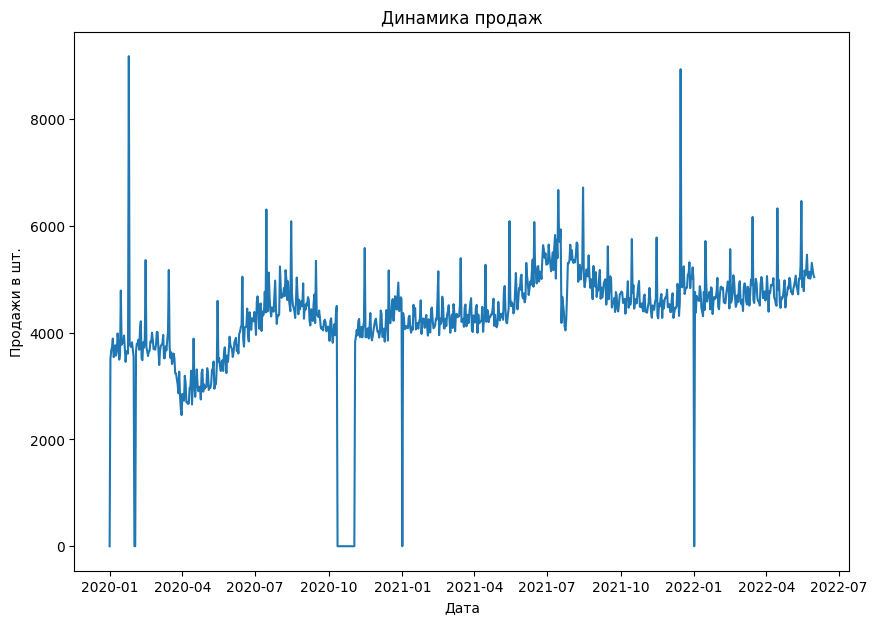

In [ ]:
plt.figure(figsize = (10,7))

plt.plot(df['date'], df['qty'])

plt.title('Динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Продажи в шт.')

plt.show()

В октябре 2020 отсутсвует ряд значений. Также отсутствуют продажи 1 января каждого года. Проверим это еще раз далее

<AxesSubplot: >

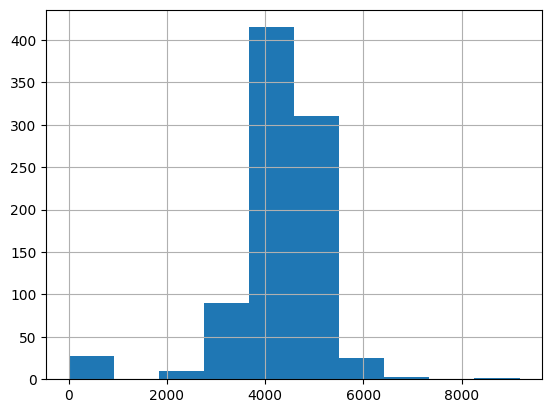

In [ ]:
# посмотрим распределение данных

df['qty'].hist(bins = 10)

In [ ]:
# для начала обработаем нулевые значения. Подтвердим теорию, что нет данных на каждое 1 января

df['year_month'] = df['date'].dt.to_period('m')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df.head()

,date,qty,year_month,month,day
0,2020-01-01,0,2020-01,1,1
1,2020-01-02,3502,2020-01,1,2
2,2020-01-03,3664,2020-01,1,3
3,2020-01-04,3727,2020-01,1,4
4,2020-01-05,3889,2020-01,1,5


In [ ]:
# посмотрим на ежегодное повторение выбросов в определенные даты. Отсортируем в порядке убывания повторения выбросов

df[['month','day','qty']].loc[df['qty']==0].value_counts().sort_values(ascending = False).head(5)

month  day  qty
1      1    0      3
2      1    0      1
       2    0      1
10     12   0      1
       13   0      1
dtype: int64

In [ ]:
# ежегодно 1 января значение отсутствует, магазины закрыты. Эти строки можно удалить

for_drop = df.loc[(df['month'] == 1) & (df['day'] == 1)]
for_drop

,date,qty,year_month,month,day
0,2020-01-01,0,2020-01,1,1
366,2021-01-01,0,2021-01,1,1
731,2022-01-01,0,2022-01,1,1


In [ ]:
df = df.drop(for_drop.index)
df

,date,qty,year_month,month,day
1,2020-01-02,3502,2020-01,1,2
2,2020-01-03,3664,2020-01,1,3
3,2020-01-04,3727,2020-01,1,4
4,2020-01-05,3889,2020-01,1,5
5,2020-01-06,3540,2020-01,1,6
...,...,...,...,...,...
877,2022-05-27,5074,2022-05,5,27
878,2022-05-28,5307,2022-05,5,28
879,2022-05-29,5201,2022-05,5,29
880,2022-05-30,5090,2022-05,5,30


Необходимо решить, чем заполнить отсутствующие значения в октябре и ноябре 2020 года - средним арифметическим значением или медианой.
Наиболее популярный способ восстановления пропущенных значений – заполнение средним значением. На практике чаще используют заполнение медианным значением, так как медиана является более устойчивым показателем к выбросам в данных. Медианное значение лучше всего отражает выборку в целом, в случае, если есть незаполненные данные. Среднее арифметическое отражает ситуацию некорректно, так как не учитывает разброс данных.

In [ ]:
# Построим график медианы количества продаж каждого месяца без учета нулевых значений

data = df.groupby(df['year_month'].loc[df['qty']>0])['qty'].median().reset_index()
data.columns = ['date', 'median_qty']
data

,date,median_qty
0,2020-01,3705.0
1,2020-02,3765.0
2,2020-03,3529.0
3,2020-04,2984.0
4,2020-05,3361.0
5,2020-06,3995.5
6,2020-07,4405.0
7,2020-08,4644.0
8,2020-09,4282.0
9,2020-10,4032.0


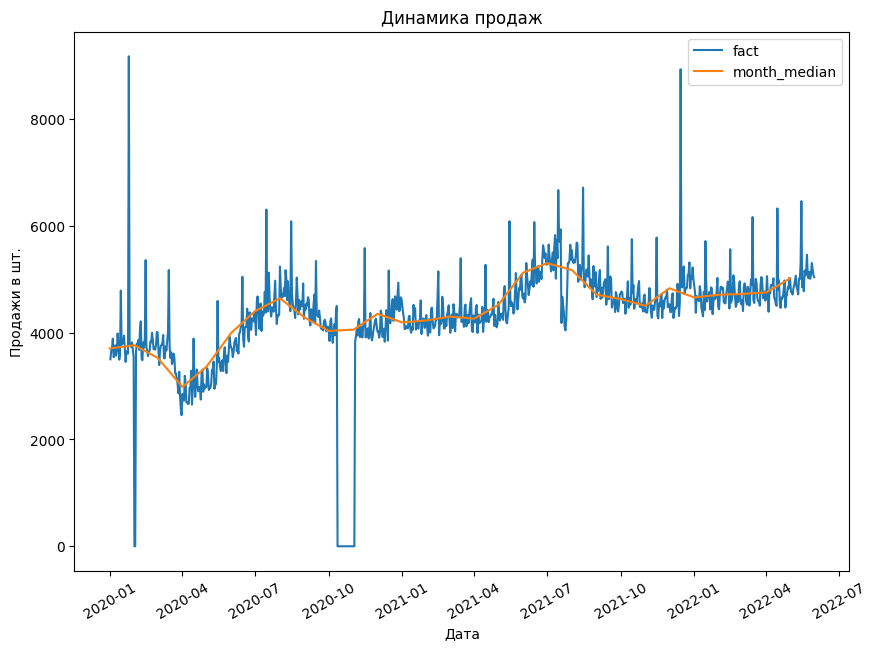

In [ ]:
plt.figure(figsize = (10,7))

plt.plot(df['date'], df['qty'])
plt.plot(data['date'].dt.to_timestamp(), data['median_qty'])
plt.title('Динамика продаж')
plt.xlabel('Дата')
plt.ylabel('Продажи в шт.')
plt.legend(['fact','month_median'])
plt.xticks(rotation = 30)

plt.show()

In [ ]:
# заменим нулевые значение на медиану соответствующего месяца

df['qty'] = df.apply(lambda x: (data['median_qty'].loc[data['date'] == x['year_month']] if x['qty'] == 0 else x['qty']), axis=1)

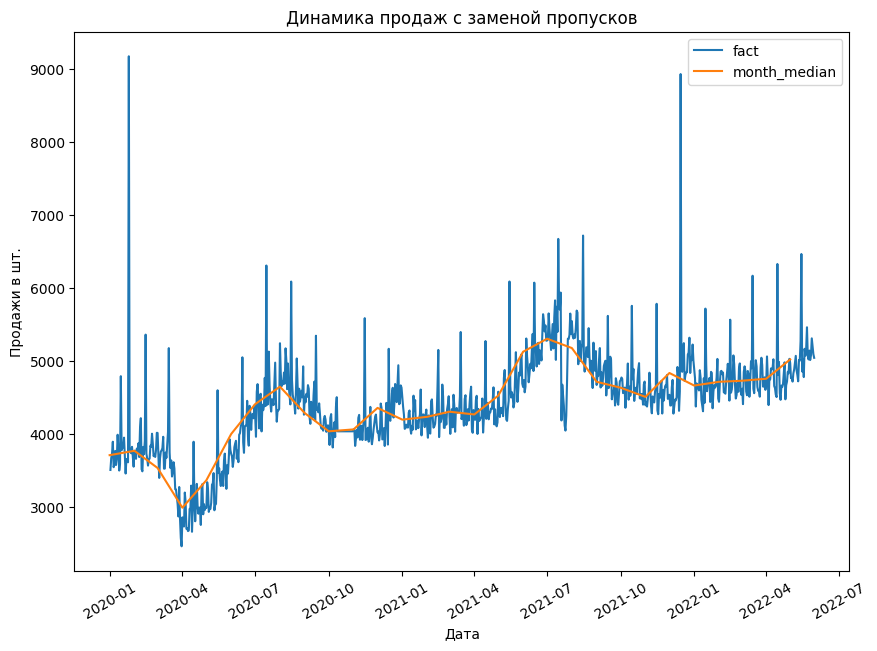

In [ ]:
# проверим замену нулевых значений по графику

plt.figure(figsize = (10,7))

plt.plot(df['date'], df['qty'])
plt.plot(data['date'].dt.to_timestamp(), data['median_qty'])
plt.title('Динамика продаж с заменой пропусков')
plt.xlabel('Дата')
plt.ylabel('Продажи в шт.')
plt.legend(['fact','month_median'])
plt.xticks(rotation = 30)

plt.show()

In [ ]:
df['qty'] = df['qty'].astype('float')
df['qty'].describe()

count     879.000000
mean     4410.796359
std       661.131298
min      2455.000000
25%      4036.500000
50%      4437.000000
75%      4774.000000
max      9176.000000
Name: qty, dtype: float64

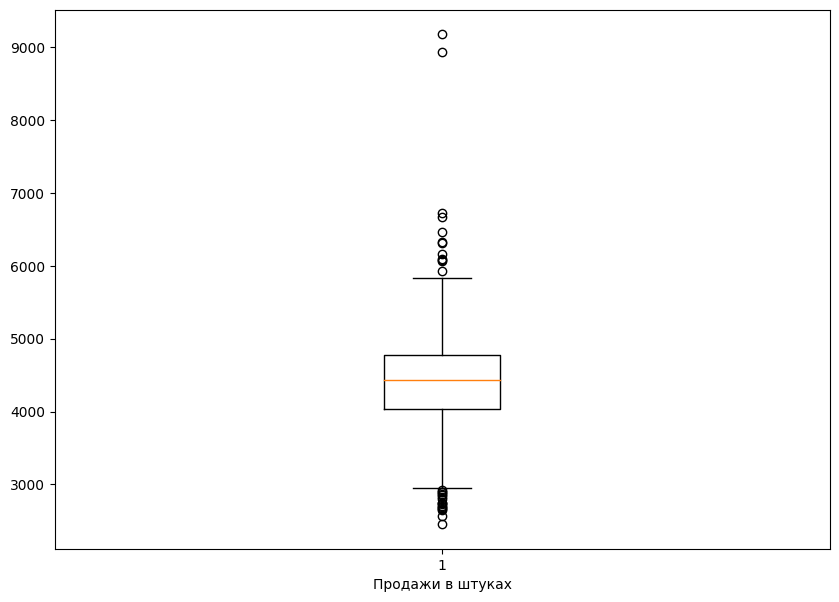

In [ ]:
# посмотрим оставшиеся выбросы 

plt.figure(figsize = (10,7))

plt.boxplot(df['qty'], showfliers = True)
plt.xlabel('Продажи в штуках')
plt.show()

In [ ]:
# удалим выбросы, используя межквартильный интервал

Q1 = df['qty'].quantile(0.25)
Q3 = df['qty'].quantile(0.75)
min = Q1 - 1.5 * (Q3 - Q1)
max = Q3 + 1.5 * (Q3 - Q1)
df = df[df['qty'].between(min,max)]
df['qty'].describe()

count     850.000000
mean     4411.121176
std       550.855934
min      2949.000000
25%      4059.250000
50%      4440.000000
75%      4765.000000
max      5828.000000
Name: qty, dtype: float64

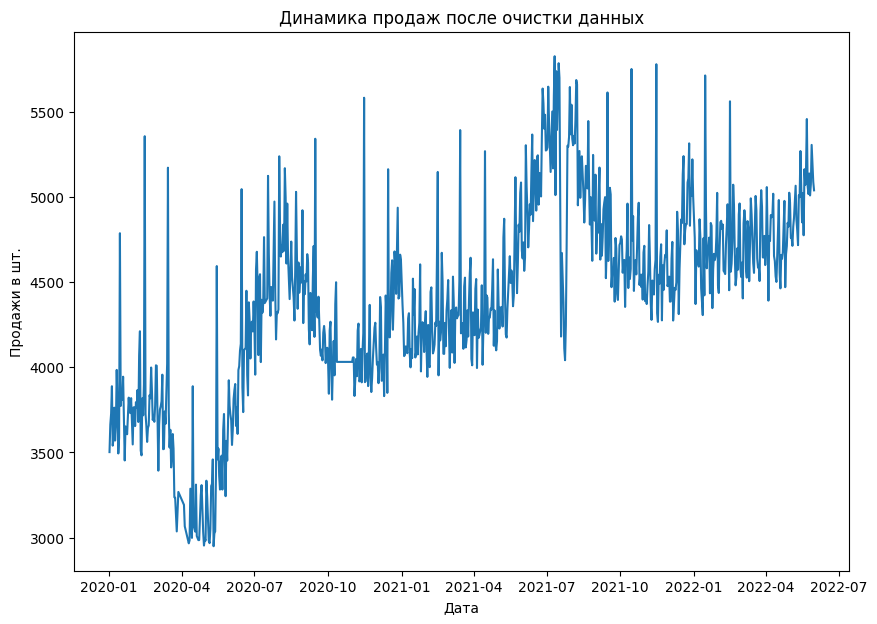

In [ ]:
# посмотрим динамику продаж после очистки данных

plt.figure(figsize = (10,7))

plt.plot(df['date'], df['qty'])

plt.title('Динамика продаж после очистки данных')
plt.xlabel('Дата')
plt.ylabel('Продажи в шт.')

plt.show()

In [ ]:
# выведем итоговый датафрейм

df = df[['date','qty']]
df

,date,qty
1,2020-01-02,3502.0
2,2020-01-03,3664.0
3,2020-01-04,3727.0
4,2020-01-05,3889.0
5,2020-01-06,3540.0
...,...,...
877,2022-05-27,5074.0
878,2022-05-28,5307.0
879,2022-05-29,5201.0
880,2022-05-30,5090.0


In [ ]:
# сохраним результат в формате Экселя

df.to_excel('result.xlsx')